In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython){
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import glob
import itertools
from openpyxl import load_workbook
from tqdm.auto import tqdm
import models as md
import log_results as lr
import matplotlib.pyplot as plt
%matplotlib inline

### Exploration

In [3]:
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
# data exploration - looking for empty values
data.count().unique()

array([299])

### Simple model example

In [5]:
TT = md.TreeTester(data=data,target='DEATH_EVENT')
TT.evaluate()

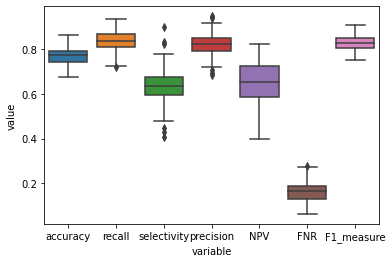

In [6]:
TT.plot_results()

### Running and saving

#### Example: first test config - all features - no oversample - no autotrain

In [7]:
# Look for already existing results dataframes, define "this test number" as "last test number + 1"
test_df_list = glob.glob("results/df/*.pkl")
try:
    test_no = max([int(elem.replace("results/df/","").replace(".pkl","").replace("df","")) for elem in test_df_list])+1
except:
    test_no = 0
    
# Test details
features = list(data.drop(['time','DEATH_EVENT'],axis=1).columns)
auto_train = False
added_features = 0
oversample = False
df_name = f'df{test_no}'

# Checking for pre existing resutlts
query = {
    'auto_train': auto_train,
    'added_features': added_features,
    'features': f"{features}",
    'oversample': oversample
}
results_logger = lr.Logger(oversample=oversample,features=features,auto_train=auto_train,
                           added_features=added_features,query=query)
if len(results_logger.find_row()):
    pass
else:
    # Running model and saving results
    TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT',oversample=oversample,
                       auto_train=auto_train,added_features=added_features)
    TT.evaluate()
    TT.evaluators.to_pickle(f'results/df/{df_name}.pkl')

    # Updating test log file
    results_logger = lr.Logger(oversample=oversample,features=features,df_name=df_name,
                               auto_train=auto_train,added_features=added_features,
                               df_results=TT.evaluators)
    results_logger.update_log()

#### Adding more and more and more configurations

In [ ]:
# Test details
auto_train = True
added_features = 1
oversample = True

for item in tqdm(list(itertools.combinations(data.drop(['time','DEATH_EVENT'],axis=1).columns,3))):
    # Check if pre-existing results can be found
    query = {
        'auto_train': auto_train,
        'added_features': added_features,
        'features': f"{list(item)}",
        'oversample': oversample
    }
    results_logger = lr.Logger(oversample=oversample,features=list(item),auto_train=auto_train,
                               added_features=added_features,query=query)
    if len(results_logger.find_row()):
        pass
    else:
        # Look for already existing results dataframes, define "this test number" as "last test number + 1"
        test_df_list = glob.glob("results/df/*.pkl")
        try:
            test_no = max([int(elem.replace("results/df/","").replace(".pkl","").replace("df","")) for elem in test_df_list])+1
        except:
            test_no = 0
        df_name = f'df{test_no}'

        # Running model and saving results
        TT = md.TreeTester(data=data,features=list(item),target='DEATH_EVENT',oversample=oversample,
                           auto_train=auto_train,added_features=added_features)
        TT.evaluate()
        TT.evaluators.to_pickle(f'results/df/{df_name}.pkl')

        # Updating test log file
        results_logger = lr.Logger(oversample=oversample,features=list(item),df_name=df_name,
                                   auto_train=auto_train,added_features=added_features,
                                   df_results=TT.evaluators)
        results_logger.update_log()

  0%|          | 0/165 [00:00<?, ?it/s]

#### Results dataframe

In [ ]:
test_log = pd.read_excel('results/df/test_log.xlsx').drop(['Unnamed: 0'],axis=1)
test_log.round(3)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE


class TreeTester():
    '''
    Object for train and test of a decision tree model.
    
    Arguments:
        features (list of strings): list of features to use as predictors (['feature0','feature1',...,]);
        train_size (float): fraction of dataset to use for train purposes;
        robustness_iteration (int): number of different train and test routines to do with a fixed configuration;
        auto_train (bool): boolean flag; allows to use the model predictions as added features;
        added_features (int): number of prediction routines to use ad added features;
        oversample (bool): activate/deactive oversampling with SMOTE technique;
        data (pandas DataFrame): original dataset
        target (string): target column.
    '''
    def __init__(self,*args,**kwargs):
        # Set default parameters
        self.features = None
        self.train_size = 0.66
        self.robustness_iterations = 100
        self.auto_train = False
        self.added_features = 0
        self.oversample = False
        self.data = pd.DataFrame()
        self.X_train = pd.DataFrame() 
        self.X_test = pd.DataFrame() 
        self.y_train = pd.DataFrame() 
        self.y_test = pd.DataFrame() 
        self.y_pred = pd.DataFrame() 
        self.target = ''
        self.classifier = tree.DecisionTreeClassifier()
        # Update with provided parameters
        self.__dict__.update(kwargs)
        # Actual initialization
        self.original_rows = len(self.data)
        self.X = self.data.drop([self.target],axis=1)
        self.y = self.data[self.target]
        self.evaluators = {}
        
        
    def train(self):
        '''
        Single train and test of the model.
        '''
        # oversampling, if needed
        X = self.X
        y = self.y
        if self.oversample:
            oversample = SMOTE()
            X,y = oversample.fit_resample(X,y)
        # feature selection
        if self.features:
            X_train, X_test, y_train, y_test = train_test_split(X[self.features], y, train_size=self.train_size,
                                                                test_size=1-self.train_size)
        else:
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=self.train_size,
                                                                test_size=1-self.train_size)
        # using model's guess as a feature
        if self.auto_train:
            for j in range(self.added_features):
                self.classifier.fit(X_train, y_train)
                X_train[f'pred_{j}'] = self.classifier.predict(X_train)
                X_test[f'pred_{j}'] = self.classifier.predict(X_test)
        self.classifier.fit(X_train, y_train)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        
    def evaluate(self):
        '''
        Constructs evaluators to rate model's performance.
        '''
        accuracy = []
        recall = []
        selectivity = []
        precision = []
        F1_measure = []
        NPV = []
        FNR = []
        for i in range(self.robustness_iterations):
            self.train()
            results = self.y_test.to_frame().rename(columns={self.target: "true_value"})
            self.y_pred = self.classifier.predict(self.X_test)
            results['predicted'] = self.y_pred
            cm = confusion_matrix(results.query('index<@self.original_rows').true_value,results.query('index<@self.original_rows').predicted)
            TP = cm[0][0]
            FP = cm[0][1]
            FN = cm[1][0]
            TN = cm[1][1]
            accuracy.append((TP+TN)/(TP+TN+FP+FN))
            recall.append(TP/(TP+FN))
            selectivity.append(TN/(TN+FP))
            precision.append(TP/(TP+FP))
            NPV.append(TN/(TN+FN))
            FNR.append(FN/(FN+TP))
            F1_measure.append(2*precision[-1]*recall[-1]/(precision[-1]+recall[-1]))
        self.evaluators['accuracy'] = accuracy
        self.evaluators['recall'] = recall
        self.evaluators['selectivity'] = selectivity
        self.evaluators['precision'] = precision
        self.evaluators['NPV'] = NPV
        self.evaluators['FNR'] = FNR
        self.evaluators['F1_measure'] = F1_measure
        self.evaluators = pd.DataFrame.from_dict(self.evaluators)
        
    
    def plot_results(self):
        '''
        Simple box-and-whiskers plot.
        '''
        fig,ax = plt.subplots()
        sns.boxplot(x="variable", y="value", data=pd.melt(self.evaluators))
        return